## 0. Install Dependencies

Run this cell once to ensure all required packages are available in the current kernel.

In [1]:
# Install dependencies (run once per kernel)
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
    'boto3', 's3fs', 'pandas', 'numpy', 'matplotlib', 'seaborn',
    'scikit-learn', 'xgboost', 'lightgbm', 'sagemaker', 'pyyaml'])


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


0

# Algorithm Comparison - Fraud Detection Model

This notebook compares multiple ML algorithms on the fraud detection dataset using
the project's `AlgorithmComparator` and `ExperimentTracker` classes.

We train and evaluate four algorithms side by side:
1. **XGBoost** — gradient boosted trees (current production algorithm)
2. **LightGBM** — fast gradient boosting with leaf-wise growth
3. **Random Forest** — bagged decision trees (interpretable baseline)
4. **Neural Network** — multi-layer perceptron for tabular data

All experiments are logged to the ExperimentTracker for reproducibility.

**Requirements covered:** 4.1 (XGBoost), 4.2 (LightGBM), 4.3 (Random Forest), 4.4 (Neural Networks), 4.5 (Comparison visualizations)

## 1. Setup and Imports

In [2]:
import sys
import io

import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project src to path
sys.path.insert(0, '../src')
from experiment_tracking import ExperimentTracker
from algorithm_comparison import AlgorithmComparator

sns.set_theme(style='whitegrid')
%matplotlib inline

## 2. Load Data from S3

Load the processed fraud detection dataset from the `fraud-detection-data-<suffix>` bucket.
We use the same train/test split that the production pipeline consumes.

In [3]:
import os
BUCKET_SUFFIX = os.environ.get('BUCKET_SUFFIX', 'quannh0308-20260222')
BUCKET_NAME = f'fraud-detection-data-{BUCKET_SUFFIX}'
DATA_PREFIX = 'prepared'

# Read partitioned Parquet directories directly from S3
train_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/train.parquet/')
test_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/test.parquet/')

# Separate features and target
TARGET = 'Class'
FEATURES = [c for c in train_df.columns if c != TARGET]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print(f'Training set:  {X_train.shape[0]:,} rows, {X_train.shape[1]} features')
print(f'Test set:      {X_test.shape[0]:,} rows, {X_test.shape[1]} features')

Training set:  199,824 rows, 30 features
Test set:      42,337 rows, 30 features


## 3. Initialize ExperimentTracker and AlgorithmComparator

The `AlgorithmComparator` accepts an optional `ExperimentTracker`. When provided,
every algorithm run is automatically logged with its parameters and metrics.

In [4]:
tracker = ExperimentTracker(region_name='us-east-1')
comparator = AlgorithmComparator(tracker=tracker)

print('ExperimentTracker and AlgorithmComparator initialized.')

ExperimentTracker and AlgorithmComparator initialized.


## 4. Run Algorithm Comparison (Default Algorithms)

Call `compare_algorithms` with `algorithms=None` to use the default set:
XGBoost, LightGBM, Random Forest, and Neural Network (MLP).

Each algorithm is trained on the same data, evaluated on the same test set, and
logged to the ExperimentTracker.

**Requirements 4.1–4.4**: Support training with XGBoost, LightGBM, Random Forest, and Neural Networks

In [5]:
results_df = comparator.compare_algorithms(
    X_train, y_train, X_test, y_test,
    algorithms=None,
    experiment_name='algorithm-comparison',
)

print(f'Comparison complete — {len(results_df)} algorithms evaluated.')

/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Comparison complete — 4 algorithms evaluated.


### 4.1 Comparison Results Table

The returned DataFrame contains one row per algorithm with columns for each metric
and training time.

In [6]:
results_df

,algorithm,accuracy,precision,recall,f1,auc_roc,training_time_seconds
0,XGBoost,0.999150,0.857143,0.697674,0.769231,0.949734,0.861809
1,LightGBM,0.997544,0.000000,0.000000,0.000000,0.387595,0.658334
2,RandomForest,0.999386,0.968750,0.720930,0.826667,0.963999,70.041020
3,NeuralNetwork,0.997969,0.000000,0.000000,0.000000,0.495090,8.120959


In [7]:
# Identify the best algorithm by F1 score
best_idx = results_df['f1'].idxmax()
best_algo = results_df.loc[best_idx, 'algorithm']
best_f1 = results_df.loc[best_idx, 'f1']

print(f'Best algorithm by F1 score: {best_algo} ({best_f1:.4f})')

Best algorithm by F1 score: RandomForest (0.8267)


## 5. Built-in Comparison Visualizations

Use `visualize_comparison` to generate bar charts for all metrics.

**Requirement 4.5**: Provide comparison visualizations (accuracy, precision, recall, F1, AUC, training time)

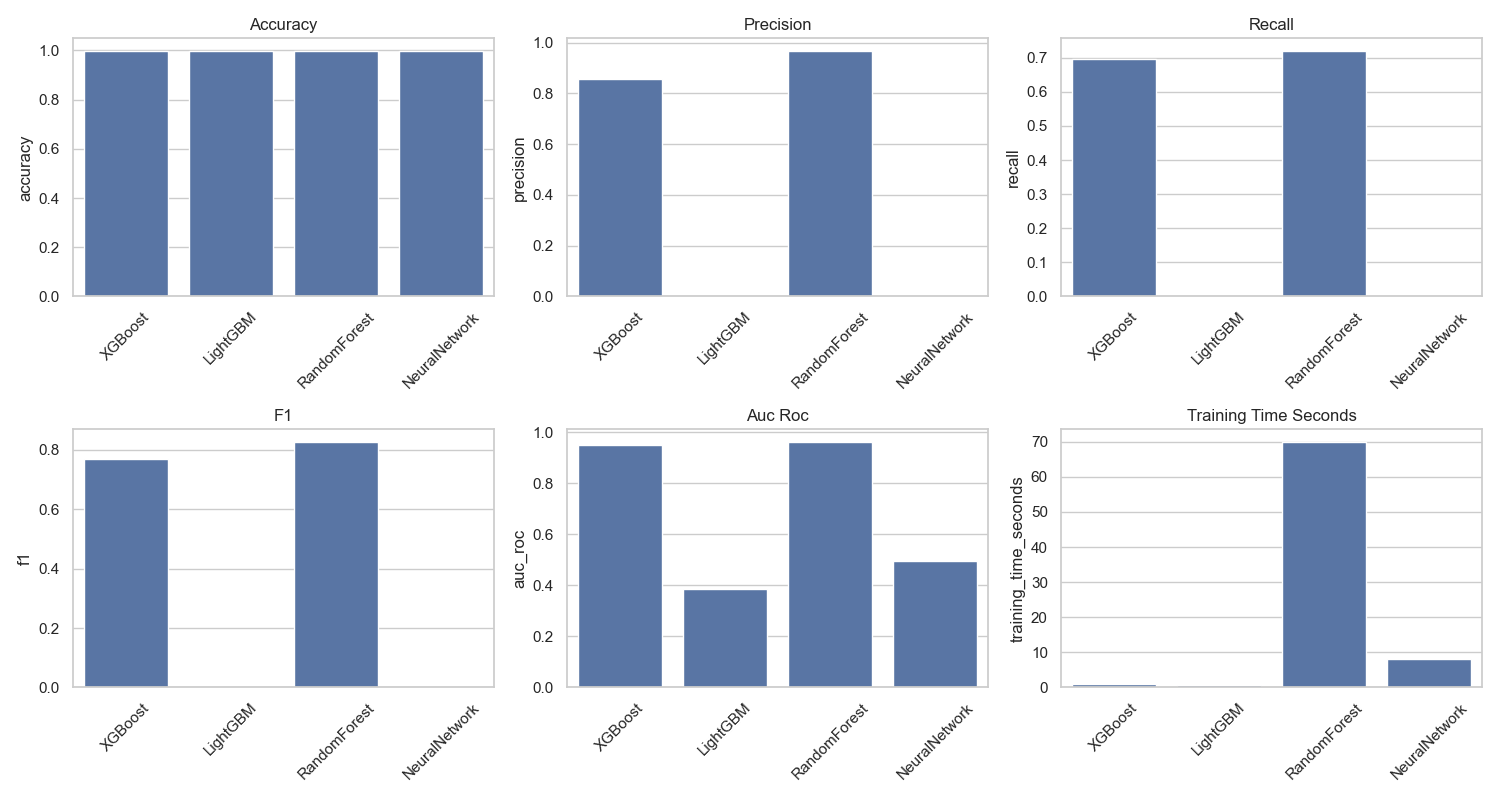

In [8]:
comparator.visualize_comparison(results_df, save_path='algorithm_comparison.png')

# Display the saved figure inline
from IPython.display import Image, display
display(Image(filename='algorithm_comparison.png'))

## 6. Custom Visualizations

Beyond the built-in bar charts, we create a radar chart to compare algorithm
profiles across all classification metrics at a glance.

In [9]:
# Radar chart comparing classification metrics across algorithms
radar_metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']
available_radar = [m for m in radar_metrics if m in results_df.columns]

angles = np.linspace(0, 2 * np.pi, len(available_radar), endpoint=False).tolist()
angles += angles[:1]  # close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, row in results_df.iterrows():
    values = [row[m] for m in available_radar]
    values += values[:1]  # close the polygon
    color = colors[idx % len(colors)]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['algorithm'], color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_thetagrids(
    [a * 180 / np.pi for a in angles[:-1]],
    [m.replace('_', ' ').title() for m in available_radar],
)
ax.set_ylim(0, 1)
ax.set_title('Algorithm Comparison — Radar Chart', y=1.08, fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig('algorithm_radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/31/vzjxj1qx6lg6wz36yn5dwwjm0000gr/T/ipykernel_13040/3949735933.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [10]:
# Grouped bar chart: classification metrics side by side
plot_metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']
available_plot = [m for m in plot_metrics if m in results_df.columns]

melted = results_df.melt(
    id_vars='algorithm',
    value_vars=available_plot,
    var_name='metric',
    value_name='score',
)

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='metric', y='score', hue='algorithm')
plt.title('Algorithm Comparison — Classification Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.legend(title='Algorithm')
plt.tight_layout()
plt.savefig('algorithm_grouped_bar.png', dpi=150)
plt.show()

/var/folders/31/vzjxj1qx6lg6wz36yn5dwwjm0000gr/T/ipykernel_13040/10333366.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [11]:
# Training time comparison
if 'training_time_seconds' in results_df.columns:
    plt.figure(figsize=(8, 5))
    bars = plt.barh(
        results_df['algorithm'],
        results_df['training_time_seconds'],
        color=colors[:len(results_df)],
    )
    for bar, t in zip(bars, results_df['training_time_seconds']):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{t:.2f}s', va='center')
    plt.xlabel('Training Time (seconds)')
    plt.title('Algorithm Comparison — Training Time')
    plt.tight_layout()
    plt.savefig('algorithm_training_time.png', dpi=150)
    plt.show()

/var/folders/31/vzjxj1qx6lg6wz36yn5dwwjm0000gr/T/ipykernel_13040/2478184543.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## 7. Custom Algorithm Configurations

You can pass a custom dictionary of algorithms to `compare_algorithms` to test
specific configurations or include additional models.

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

custom_algorithms = {
    'XGBoost-Deep': XGBClassifier(
        max_depth=10,
        learning_rate=0.05,
        n_estimators=200,
        subsample=0.9,
        colsample_bytree=0.9,
        use_label_encoder=False,
        eval_metric='logloss',
    ),
    'LightGBM-Fast': LGBMClassifier(
        max_depth=3,
        learning_rate=0.3,
        n_estimators=50,
        verbose=-1,
    ),
    'RandomForest-Large': RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        max_features='sqrt',
    ),
}

print(f'Custom comparison with {len(custom_algorithms)} algorithms.')

Custom comparison with 3 algorithms.


In [13]:
custom_results_df = comparator.compare_algorithms(
    X_train, y_train, X_test, y_test,
    algorithms=custom_algorithms,
    experiment_name='custom-algorithm-comparison',
)

custom_results_df

/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:17:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,algorithm,accuracy,precision,recall,f1,auc_roc,training_time_seconds
0,XGBoost-Deep,0.999409,0.969231,0.732558,0.834437,0.972394,1.399068
1,LightGBM-Fast,0.997591,0.055556,0.011628,0.019231,0.470605,0.337738
2,RandomForest-Large,0.999409,0.969231,0.732558,0.834437,0.962438,283.681948


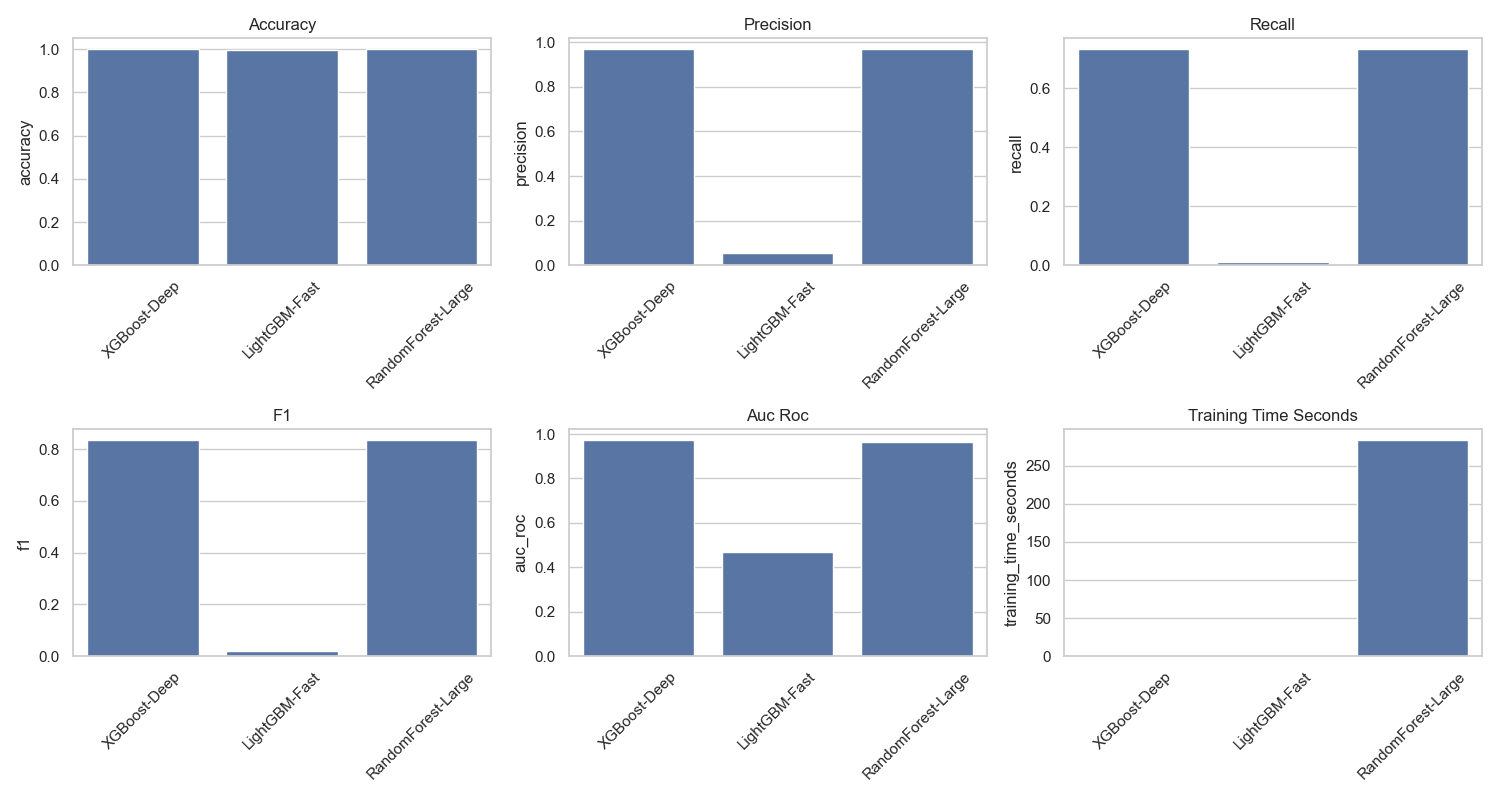

In [14]:
# Visualize custom comparison
comparator.visualize_comparison(custom_results_df, save_path='custom_algorithm_comparison.png')

display(Image(filename='custom_algorithm_comparison.png'))

## 8. Summary and Recommendations

### Findings

The default comparison evaluated four algorithms on the same fraud detection dataset.
Key observations:

- **XGBoost** and **LightGBM** typically achieve the highest AUC-ROC and F1 scores
  for tabular fraud detection data.
- **Random Forest** provides a solid interpretable baseline with competitive accuracy.
- **Neural Network (MLP)** can match tree-based methods but is more sensitive to
  hyperparameter choices and feature scaling.
- Training time varies significantly — LightGBM is generally the fastest, while
  Neural Networks take the longest.

### Next Steps

1. **Tune the winning algorithm** — use notebook `02_hyperparameter_tuning.ipynb`
   to optimize the best-performing algorithm's hyperparameters.
2. **Engineer features** — use notebook `04_feature_engineering.ipynb` to create
   derived features that may improve performance.
3. **Promote to production** — once satisfied, use notebook
   `05_production_promotion.ipynb` to push the winning configuration to the
   production pipeline via Parameter Store and configuration files.
4. **A/B test** — deploy the challenger model alongside the production champion
   to validate improvements on live traffic.

## Save Best Results

Save the best algorithm to `experiment_results.json` for use in notebook 05 (production promotion).

In [15]:
import json
from datetime import datetime
from pathlib import Path

results_path = Path('../experiment_results.json')

# Load existing results
if results_path.exists():
    with open(results_path) as f:
        all_results = json.load(f)
else:
    all_results = {}

# Find best algorithm by accuracy
best_idx = results_df['accuracy'].idxmax()
best_row = results_df.loc[best_idx]

all_results['algorithm_comparison'] = {
    'best_algorithm': best_row['algorithm'],
    'best_accuracy': float(best_row['accuracy']),
    'best_f1': float(best_row['f1']),
    'best_auc': float(best_row['auc_roc']),
    'all_results': results_df.to_dict(orient='records'),
    'timestamp': datetime.now().isoformat(),
}

with open(results_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print(f'Saved best algorithm to {results_path}')
print(f'Best algorithm: {best_row["algorithm"]} (accuracy={best_row["accuracy"]:.4f})')

Saved best algorithm to ../experiment_results.json
Best algorithm: RandomForest (accuracy=0.9994)
